Environment OK. XGBoost version: 3.0.4
No CSV found. Please upload your CSV (e.g., 1-minute OHLCV).


Saving btcusd_1-min_data.csv to btcusd_1-min_data.csv
Using CSV: btcusd_1-min_data.csv
After resampling: (406008, 6) 2014-01-01 00:00:00 -> 2025-08-01 00:45:00


,datetime,Close,Open,High,Low,Volume
0,2014-01-01 00:00:00,733.000000,734.330017,734.330017,731.510010,8.049860
1,2014-01-01 00:15:00,729.210022,732.539978,732.539978,729.030029,57.775120
2,2014-01-01 00:30:00,727.000000,729.200012,729.210022,726.989990,37.522472


,datetime,Close,Open,High,Low,Volume
406005,2025-08-01 00:15:00,115783.0,115300.0,115908.0,115300.0,28.405737
406006,2025-08-01 00:30:00,115508.0,115773.0,115783.0,115425.0,24.822092
406007,2025-08-01 00:45:00,115425.0,115506.0,115514.0,114322.0,122.860298


After feature engineering: (405816, 38)
Split sizes -> Train:292188  Valid:32465  Test:81163  (Total:405816)
Final shapes: (292188, 36) (32465, 36) (81163, 36)
MAE:  1.637809
RMSE: 16.435170
MSE:  270.114807
MAPE: 0.0025%
R^2:  1.000000
Saved metrics -> metrics_xgb.csv


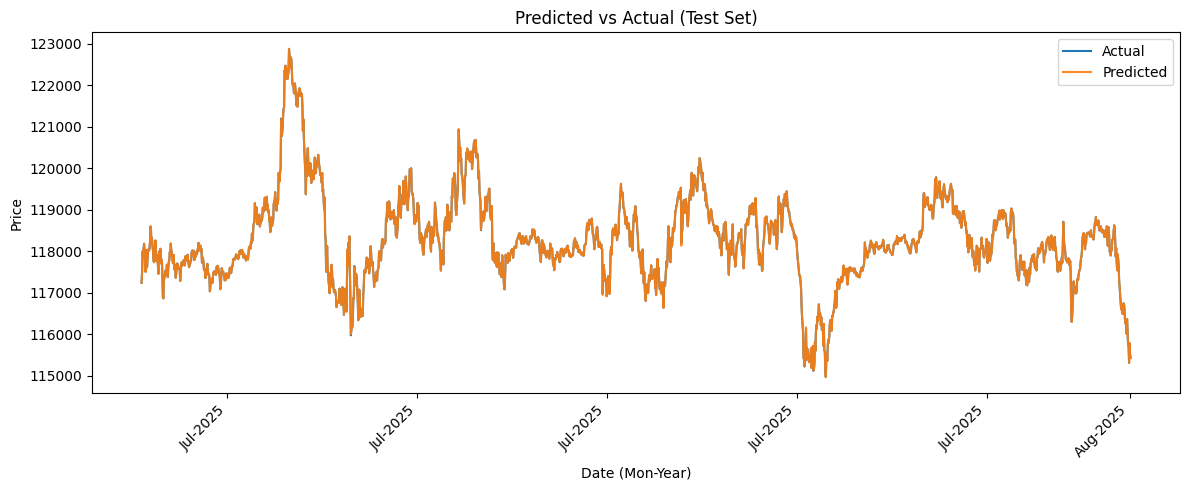

Saved plot -> pred_vs_actual.png
Saved predictions -> predictions_test.csv


,datetime,base_price_t,true_ret,pred_ret,actual_price_t+1,predicted_price_t+1
81153,2025-07-31 22:15:00,116270.0,-0.000576,-0.000569,116203.000000,116203.898438
81154,2025-07-31 22:30:00,116203.0,-0.001678,-0.001687,116008.000000,116006.968750
81155,2025-07-31 22:45:00,116008.0,0.003069,0.003095,116364.007812,116367.023438
81156,2025-07-31 23:00:00,116364.0,-0.002862,-0.002863,116031.000000,116030.828125
81157,2025-07-31 23:15:00,116031.0,-0.002517,-0.002500,115739.000000,115740.914062
81158,2025-07-31 23:30:00,115739.0,0.000095,0.000094,115750.000000,115749.875000
81159,2025-07-31 23:45:00,115750.0,-0.003819,-0.003815,115308.000000,115308.468750
81160,2025-08-01 00:00:00,115308.0,0.004119,0.004112,115783.000000,115782.187500
81161,2025-08-01 00:15:00,115783.0,-0.002375,-0.002383,115508.000000,115507.070312
81162,2025-08-01 00:30:00,115508.0,-0.000719,-0.000729,115425.000000,115423.820312


In [1]:
import sys, gc, math, locale, os, glob, warnings, random, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
try:
    import locale as _loc
    _loc.setlocale(_loc.LC_TIME, 'C')
except Exception:
    pass
try:
    import xgboost as xgb
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost==1.7.6'])
    import xgboost as xgb
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print('Environment OK. XGBoost version:', xgb.__version__)
DEFAULT_CSV_CANDIDATES = ['btcusd_1-min_data.csv', 'BTCUSD_1min.csv', 'data.csv']
START_DATE = '2014-01-01'
RESAMPLE_RULE = '15T'
TARGET_HORIZON = 1
LAGS = [1, 2, 4, 8, 16, 32, 96]
ROLL_WINDOWS = [4, 16, 96, 192]
TEST_RATIO = 0.2
VALID_RATIO = 0.1
N_PLOT_POINTS = 2000
from typing import Optional
PRICE_COL_CANDIDATES = ['Close', 'close', 'Weighted_Price', 'Price', 'price', 'Adj Close', 'Adj_Close']
VOL_COL_CANDIDATES = ['Volume', 'Volume_(BTC)', 'Volume_(Currency)', 'Vol', 'vol']
TIME_COL_CANDIDATES = ['Timestamp', 'timestamp', 'Date', 'date', 'Datetime', 'datetime', 'Time', 'time']
HIGH_COLS = ['High', 'high']
LOW_COLS = ['Low', 'low']
OPEN_COLS = ['Open', 'open']

def pick_first_existing(df: pd.DataFrame, names) -> Optional[str]:
    for n in names:
        if n in df.columns:
            return n
    return None

def to_datetime_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        dt = pd.to_datetime(s, unit='s', errors='coerce', utc=True)
    else:
        dt = pd.to_datetime(s, errors='coerce', utc=True)
    try:
        dt = dt.dt.tz_localize(None)
    except Exception:
        dt = pd.to_datetime(dt, errors='coerce')
    return dt

def read_and_resample_large_csv(path: str, start_date: str=START_DATE, rule: str=RESAMPLE_RULE) -> pd.DataFrame:
    first_chunk = pd.read_csv(path, nrows=5000)
    tcol = pick_first_existing(first_chunk, TIME_COL_CANDIDATES)
    pcol = pick_first_existing(first_chunk, PRICE_COL_CANDIDATES)
    vcol = pick_first_existing(first_chunk, VOL_COL_CANDIDATES)
    hcol = pick_first_existing(first_chunk, HIGH_COLS)
    lcol = pick_first_existing(first_chunk, LOW_COLS)
    ocol = pick_first_existing(first_chunk, OPEN_COLS)
    if tcol is None or pcol is None:
        raise ValueError('Cannot detect time or price column in CSV.')
    usecols = [tcol, pcol] + [c for c in [vcol, hcol, lcol, ocol] if c]
    usecols = list(dict.fromkeys(usecols))
    chunk_list = []
    start_dt = pd.to_datetime(start_date)
    chunksize = 2000000
    for chunk in pd.read_csv(path, usecols=usecols, chunksize=chunksize):
        dt = to_datetime_series(chunk[tcol])
        mask = dt >= start_dt
        if not mask.any():
            continue
        c = chunk.loc[mask].copy()
        c['dt_bin'] = dt.loc[mask].dt.floor(rule)
        c.rename(columns={pcol: 'Close'}, inplace=True)
        if vcol and vcol in c.columns:
            c.rename(columns={vcol: 'Volume'}, inplace=True)
        if hcol and hcol in c.columns:
            c.rename(columns={hcol: 'High'}, inplace=True)
        if lcol and lcol in c.columns:
            c.rename(columns={lcol: 'Low'}, inplace=True)
        if ocol and ocol in c.columns:
            c.rename(columns={ocol: 'Open'}, inplace=True)
        agg = {'Close': 'last'}
        if 'Open' in c.columns:
            agg['Open'] = 'first'
        if 'High' in c.columns:
            agg['High'] = 'max'
        if 'Low' in c.columns:
            agg['Low'] = 'min'
        if 'Volume' in c.columns:
            agg['Volume'] = 'sum'
        res = c.groupby('dt_bin', as_index=False).agg(agg).rename(columns={'dt_bin': 'datetime'})
        chunk_list.append(res)
    if not chunk_list:
        raise ValueError('No rows after START_DATE filter; check file and START_DATE.')
    df = pd.concat(chunk_list, ignore_index=True)
    agg_final = {'Close': 'last'}
    for col in ['Open', 'High', 'Low', 'Volume']:
        if col in df.columns:
            agg_final[col] = 'sum' if col == 'Volume' else 'first' if col == 'Open' else 'max' if col == 'High' else 'min'
    df = df.groupby('datetime', as_index=False).agg(agg_final)
    df = df.sort_values('datetime').reset_index(drop=True)
    for col in df.columns:
        if col != 'datetime':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['Close'], inplace=True)
    return df

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['return_1'] = out['Close'].pct_change(1).astype('float32')
    out['return_4'] = out['Close'].pct_change(4).astype('float32')
    out['return_16'] = out['Close'].pct_change(16).astype('float32')
    for l in LAGS:
        out[f'lag_{l}'] = out['Close'].shift(l).astype('float32')
    for w in ROLL_WINDOWS:
        out[f'roll_mean_{w}'] = out['Close'].rolling(w).mean().astype('float32')
        out[f'roll_std_{w}'] = out['Close'].rolling(w).std().astype('float32')
        if 'Volume' in out.columns:
            out[f'vol_mean_{w}'] = out['Volume'].rolling(w).mean().astype('float32')
            out[f'vol_std_{w}'] = out['Volume'].rolling(w).std().astype('float32')
    if 'High' in out.columns and 'Low' in out.columns:
        out['hl_range'] = (out['High'] - out['Low']).astype('float32')
    dt = pd.to_datetime(out['datetime'])
    out['hour'] = dt.dt.hour.astype('int16')
    out['dayofweek'] = dt.dt.dayofweek.astype('int16')
    out['month'] = dt.dt.month.astype('int16')
    out['fwd_ret_1'] = (out['Close'].shift(-TARGET_HORIZON) / out['Close'] - 1.0).astype('float32')
    out['target'] = out['fwd_ret_1']
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    out = out.dropna().reset_index(drop=True)
    return out

def time_series_splits(n: int, test_ratio: float, valid_ratio: float):
    test_size = int(n * test_ratio)
    train_valid_size = n - test_size
    valid_size = int(train_valid_size * valid_ratio)
    train_size = train_valid_size - valid_size
    return (train_size, valid_size, test_size)
csv_path = None
for cand in DEFAULT_CSV_CANDIDATES:
    if os.path.exists(cand):
        csv_path = cand
        break
if csv_path is None:
    files = glob.glob('*.csv')
    if files:
        files.sort(key=lambda p: os.path.getsize(p), reverse=True)
        csv_path = files[0]
if csv_path is None:
    print('No CSV found. Please upload your CSV (e.g., 1-minute OHLCV).')
    try:
        from google.colab import files
        uploaded = files.upload()
        csv_path = list(uploaded.keys())[0]
    except Exception as e:
        raise RuntimeError('File upload failed. Please re-run and upload a CSV.') from e
print(f'Using CSV: {csv_path}')
df = read_and_resample_large_csv(csv_path, start_date=START_DATE, rule=RESAMPLE_RULE)
print('After resampling:', df.shape, df['datetime'].min(), '->', df['datetime'].max())
display(df.head(3))
display(df.tail(3))
feat_df = make_features(df)
print('After feature engineering:', feat_df.shape)
del df
gc.collect()
FEATURES = [c for c in feat_df.columns if c not in ('datetime', 'target')]
X = feat_df[FEATURES].astype('float32').values
y = feat_df['target'].astype('float32').values
dt_vec = pd.to_datetime(feat_df['datetime']).values
CLOSE_VEC = feat_df['Close'].astype('float32').values
n = len(feat_df)
trn_sz, val_sz, tst_sz = time_series_splits(n, TEST_RATIO, VALID_RATIO)
print(f'Split sizes -> Train:{trn_sz}  Valid:{val_sz}  Test:{tst_sz}  (Total:{n})')
X_train, y_train = (X[:trn_sz], y[:trn_sz])
X_valid, y_valid = (X[trn_sz:trn_sz + val_sz], y[trn_sz:trn_sz + val_sz])
X_test, y_test = (X[trn_sz + val_sz:], y[trn_sz + val_sz:])
dt_test = dt_vec[trn_sz + val_sz:]
base_test = CLOSE_VEC[trn_sz + val_sz:]

def clean_xyb(X, y, b):
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y) & np.isfinite(b)
    return (X[mask], y[mask], b[mask], mask)
X_train, y_train, _, _ = clean_xyb(X_train, y_train, np.ones_like(y_train))
X_valid, y_valid, _, _ = clean_xyb(X_valid, y_valid, np.ones_like(y_valid))
X_test, y_test, base_test, m = clean_xyb(X_test, y_test, base_test)
dt_test = dt_test[m]
print('Final shapes:', X_train.shape, X_valid.shape, X_test.shape)
model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', max_depth=8, learning_rate=0.05, n_estimators=2000, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0, random_state=SEED, n_jobs=2)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)
y_pred_ret = model.predict(X_test)
y_true_ret = y_test
y_pred_price = base_test * (1.0 + y_pred_ret)
y_true_price = base_test * (1.0 + y_true_ret)
mae = mean_absolute_error(y_true_price, y_pred_price)
mse = mean_squared_error(y_true_price, y_pred_price)
rmse = math.sqrt(mse)
mape = np.abs((y_true_price - y_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2 = r2_score(y_true_price, y_pred_price)
print(f'MAE:  {mae:,.6f}')
print(f'RMSE: {rmse:,.6f}')
print(f'MSE:  {mse:,.6f}')
print(f'MAPE: {mape:,.4f}%')
print(f'R^2:  {r2:,.6f}')
pd.DataFrame([{'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'MAPE(%)': mape, 'R2': r2, 'best_ntree_limit': getattr(model, 'best_ntree_limit', None)}]).to_csv('metrics_xgb.csv', index=False)
print('Saved metrics -> metrics_xgb.csv')
plt.figure(figsize=(12, 5))
npts = len(y_true_price)
start_idx = max(0, npts - N_PLOT_POINTS)
plt.plot(dt_test[start_idx:], y_true_price[start_idx:], label='Actual')
plt.plot(dt_test[start_idx:], y_pred_price[start_idx:], label='Predicted', alpha=0.9)
plt.title('Predicted vs Actual (Test Set)')
plt.xlabel('Date (Mon-Year)')
plt.ylabel('Price')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pred_vs_actual.png', dpi=140)
plt.show()
print('Saved plot -> pred_vs_actual.png')
out = pd.DataFrame({'datetime': pd.to_datetime(dt_test), 'base_price_t': base_test.astype('float64'), 'true_ret': y_true_ret.astype('float64'), 'pred_ret': y_pred_ret.astype('float64'), 'actual_price_t+1': y_true_price.astype('float64'), 'predicted_price_t+1': y_pred_price.astype('float64')})
out.to_csv('predictions_test.csv', index=False)
print('Saved predictions -> predictions_test.csv')
display(out.tail(10))


In [ ]:
leak = set(['fwd_ret_1', 'target']) & set(FEATURES)
print('Leak columns inside FEATURES:', leak)
import numpy as np, math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
naive_pred_price = base_test
mae_b = mean_absolute_error(y_true_price, naive_pred_price)
mse_b = mean_squared_error(y_true_price, naive_pred_price)
rmse_b = math.sqrt(mse_b)
mape_b = np.abs((y_true_price - naive_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100
r2_b = r2_score(y_true_price, naive_pred_price)
print(f'[Naive] MAE:{mae_b:,.2f} RMSE:{rmse_b:,.2f} MAPE:{mape_b:.3f}% R^2:{r2_b:.4f}')
import pandas as pd
resid = pd.Series(y_true_price - y_pred_price, index=pd.to_datetime(dt_test), name='residual')
print(resid.describe())


Leak columns inside FEATURES: {'fwd_ret_1'}
[Naive] MAE:104.77 RMSE:176.71 MAPE:0.160% R^2:1.0000
count    81163.000000
mean         0.012762
std         16.434259
min      -1534.359375
25%         -0.468750
50%          0.003906
75%          0.460938
max        982.625000
Name: residual, dtype: float64


Shapes (no-leak): (292188, 35) (32465, 35) (81163, 35)
[0]	train-rmse:0.00457	valid-rmse:0.00328
[50]	train-rmse:0.00431	valid-rmse:0.00328
[100]	train-rmse:0.00418	valid-rmse:0.00328
[126]	train-rmse:0.00411	valid-rmse:0.00328
Best iteration (0-based): 27
First 5 train rmse: [0.00457279537227331, 0.00456339649523276, 0.0045520491612396, 0.00454107641158773, 0.00453115384952341]
First 5 valid rmse: [0.0032805686710137, 0.00328030705749233, 0.00328055570646042, 0.00327980491962966, 0.00328042219100961]
Last 5 train rmse : [0.0041187737299987, 0.00411564812604893, 0.00411316537797703, 0.00411154059599256, 0.00410973890875168]
Last 5 valid rmse : [0.0032816122960964, 0.00328191935141082, 0.00328196865450367, 0.00328199730298468, 0.00328198412154545]


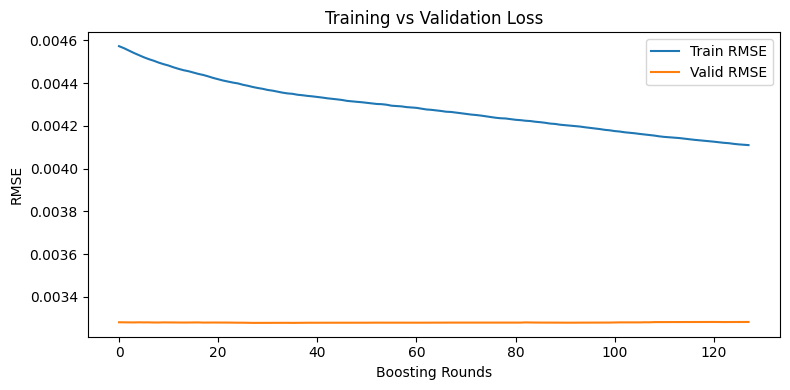

Saved -> rmse_curve.png
Saved model -> models/xgb_model.json (.ubj), config -> models/xgb_config.json, meta -> models/xgb_meta.json
Saved model -> models/xgb_model.json (.ubj), meta -> models/xgb_meta.json
[Model] MAE:104.73  RMSE:176.87  MSE:31,283.50  MAPE:0.1602%  R^2:0.999960
[Naive] MAE:104.77  RMSE:176.71  MAPE:0.1602%  R^2:0.999960
Saved -> metrics_xgb.csv, predictions_test.csv


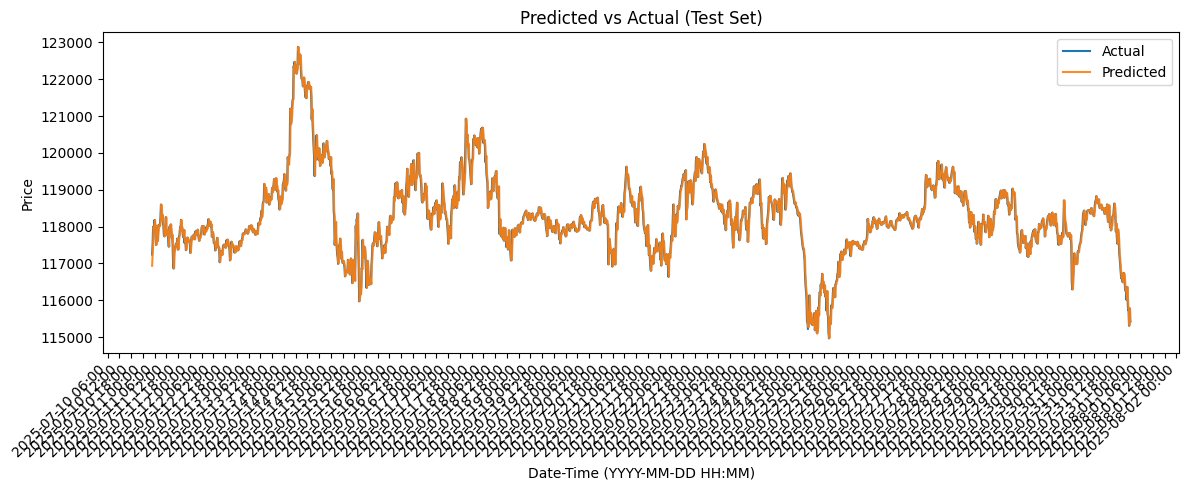

Saved plot -> pred_vs_actual.png


In [2]:
import numpy as np, math, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
FEATURES = [c for c in feat_df.columns if c not in ('datetime', 'target', 'fwd_ret_1')]
assert 'fwd_ret_1' not in FEATURES and 'target' not in FEATURES, 'Leakage detected, check FEATURES.'
X = feat_df[FEATURES].astype('float32').values
y = feat_df['target'].astype('float32').values
dt_vec = pd.to_datetime(feat_df['datetime']).values
CLOSE_VEC = feat_df['Close'].astype('float32').values
n = len(feat_df)
trn_sz, val_sz, tst_sz = time_series_splits(n, TEST_RATIO, VALID_RATIO)
X_train, y_train = (X[:trn_sz], y[:trn_sz])
X_valid, y_valid = (X[trn_sz:trn_sz + val_sz], y[trn_sz:trn_sz + val_sz])
X_test, y_test = (X[trn_sz + val_sz:], y[trn_sz + val_sz:])
dt_test = dt_vec[trn_sz + val_sz:]
base_test = CLOSE_VEC[trn_sz + val_sz:]

def clean_xyb(X, y, b):
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y) & np.isfinite(b)
    return (X[mask], y[mask], b[mask], mask)
X_train, y_train, _, _ = clean_xyb(X_train, y_train, np.ones_like(y_train))
X_valid, y_valid, _, _ = clean_xyb(X_valid, y_valid, np.ones_like(y_valid))
X_test, y_test, base_test, m = clean_xyb(X_test, y_test, base_test)
dt_test = dt_test[m]
print('Shapes (no-leak):', X_train.shape, X_valid.shape, X_test.shape)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test)
params = {'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_depth': 8, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 0.0, 'lambda': 1.0, 'seed': SEED, 'eval_metric': 'rmse'}
evallist = [(dtrain, 'train'), (dvalid, 'valid')]
num_boost_round = 2000
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=evallist, early_stopping_rounds=100, verbose_eval=50, evals_result=evals_result)
best_iter = getattr(bst, 'best_iteration', None)
if best_iter is not None:
    print('Best iteration (0-based):', best_iter)
train_rmse = evals_result['train']['rmse']
valid_rmse = evals_result['valid']['rmse']
print('First 5 train rmse:', train_rmse[:5])
print('First 5 valid rmse:', valid_rmse[:5])
print('Last 5 train rmse :', train_rmse[-5:])
print('Last 5 valid rmse :', valid_rmse[-5:])
plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Valid RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig('rmse_curve.png', dpi=140)
plt.show()
print('Saved -> rmse_curve.png')
import os, json
os.makedirs('models', exist_ok=True)
import os, json
os.makedirs('models', exist_ok=True)
bst.save_model('models/xgb_model.json')
bst.save_model('models/xgb_model.ubj')
cfg = bst.save_config()
with open('models/xgb_config.json', 'w') as f:
    f.write(cfg)
meta = {'best_iteration': int(best_iter) if best_iter is not None else None, 'features': FEATURES, 'resample_rule': RESAMPLE_RULE, 'target_horizon': TARGET_HORIZON, 'start_date': START_DATE, 'eval_metric': 'rmse'}
with open('models/xgb_meta.json', 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)
print('Saved model -> models/xgb_model.json (.ubj), config -> models/xgb_config.json, meta -> models/xgb_meta.json')
print('Saved model -> models/xgb_model.json (.ubj), meta -> models/xgb_meta.json')
if best_iter is not None:
    y_pred_ret = bst.predict(dtest, iteration_range=(0, best_iter + 1))
else:
    y_pred_ret = bst.predict(dtest)
y_true_ret = y_test
y_pred_price = base_test * (1.0 + y_pred_ret)
y_true_price = base_test * (1.0 + y_true_ret)
mae = mean_absolute_error(y_true_price, y_pred_price)
mse = mean_squared_error(y_true_price, y_pred_price)
rmse = math.sqrt(mse)
mape = np.abs((y_true_price - y_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2 = r2_score(y_true_price, y_pred_price)
print(f'[Model] MAE:{mae:,.2f}  RMSE:{rmse:,.2f}  MSE:{mse:,.2f}  MAPE:{mape:.4f}%  R^2:{r2:.6f}')
naive_pred_price = base_test
mae_b = mean_absolute_error(y_true_price, naive_pred_price)
mse_b = mean_squared_error(y_true_price, naive_pred_price)
rmse_b = math.sqrt(mse_b)
mape_b = np.abs((y_true_price - naive_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2_b = r2_score(y_true_price, naive_pred_price)
print(f'[Naive] MAE:{mae_b:,.2f}  RMSE:{rmse_b:,.2f}  MAPE:{mape_b:.4f}%  R^2:{r2_b:.6f}')
pd.DataFrame([{'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'MAPE(%)': mape, 'R2': r2, 'baseline_MAE': mae_b, 'baseline_RMSE': rmse_b, 'baseline_MAPE(%)': mape_b, 'baseline_R2': r2_b, 'best_iteration': best_iter}]).to_csv('metrics_xgb.csv', index=False)
out = pd.DataFrame({'datetime': pd.to_datetime(dt_test), 'base_price_t': base_test.astype('float64'), 'true_ret': y_true_ret.astype('float64'), 'pred_ret': y_pred_ret.astype('float64'), 'actual_price_t+1': y_true_price.astype('float64'), 'predicted_price_t+1': y_pred_price.astype('float64')})
out.to_csv('predictions_test.csv', index=False)
print('Saved -> metrics_xgb.csv, predictions_test.csv')
plt.figure(figsize=(12, 5))
npts = len(y_true_price)
start_idx = max(0, npts - N_PLOT_POINTS)
plt.plot(dt_test[start_idx:], y_true_price[start_idx:], label='Actual')
plt.plot(dt_test[start_idx:], y_pred_price[start_idx:], label='Predicted', alpha=0.9)
plt.title('Predicted vs Actual (Test Set)')
plt.xlabel('Date-Time (YYYY-MM-DD HH:MM)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig('pred_vs_actual.png', dpi=140)
plt.show()
print('Saved plot -> pred_vs_actual.png')


In [ ]:
import os, glob, json, xgboost as xgb
paths = ['models/xgb_model.json', 'models/xgb_model.ubj', 'models/xgb_config.json', 'models/xgb_meta.json']
print('Existing files:')
for p in paths:
    print('1' if os.path.exists(p) else '2', p, os.path.getsize(p) if os.path.exists(p) else 0)
if os.path.exists('models/xgb_model.json'):
    bst = xgb.Booster()
    bst.load_model('models/xgb_model.json')
    print(' Booster loaded')
    if os.path.exists('models/xgb_meta.json'):
        with open('models/xgb_meta.json', 'r', encoding='utf-8') as f:
            meta = json.load(f)
        print('Meta:', {k: meta.get(k) for k in ['best_iteration', 'resample_rule', 'target_horizon']})


Existing files:
1 models/xgb_model.json 1979673
1 models/xgb_model.ubj 1269921
1 models/xgb_config.json 1643
1 models/xgb_meta.json 717
 Booster loaded
Meta: {'best_iteration': 27, 'resample_rule': '15T', 'target_horizon': 1}


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p /content/drive/MyDrive/xgb_backup
!cp -v models/xgb_model.* models/xgb_config.json models/xgb_meta.json /content/drive/MyDrive/xgb_backup/


Mounted at /content/drive
'models/xgb_model.json' -> '/content/drive/MyDrive/xgb_backup/xgb_model.json'
'models/xgb_model.ubj' -> '/content/drive/MyDrive/xgb_backup/xgb_model.ubj'
'models/xgb_config.json' -> '/content/drive/MyDrive/xgb_backup/xgb_config.json'
'models/xgb_meta.json' -> '/content/drive/MyDrive/xgb_backup/xgb_meta.json'


 Model loaded. best_iteration = 27
 Features count: 35
Test shape: (81163, 35)
Pred sample (returns): [-1.6538192e-05 -1.3042860e-05 -1.6538192e-05 -1.6538192e-05
 -1.6538192e-05]
[LoadedModel] MAE:104.73  RMSE:176.87  MSE:31,283.50  MAPE:0.1602%  R^2:0.999960
Saved -> inference_from_saved.csv


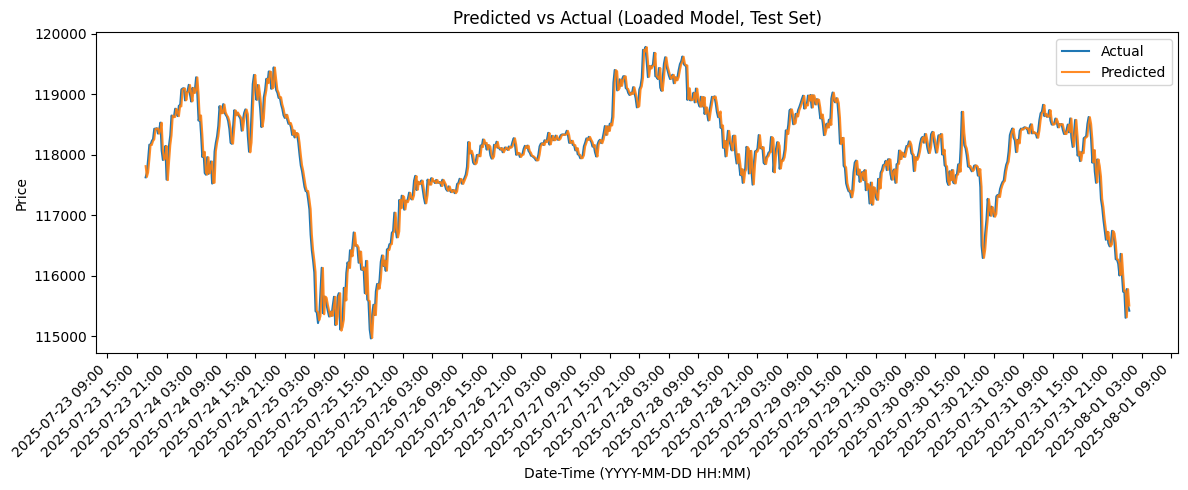

Saved plot -> pred_vs_actual_loaded.png


In [4]:
import os, json, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
paths = ['models/xgb_model.json', 'models/xgb_meta.json']
assert all((os.path.exists(p) for p in paths)), f'模型或meta不存在: {paths}'
bst = xgb.Booster()
bst.load_model('models/xgb_model.json')
with open('models/xgb_meta.json', 'r', encoding='utf-8') as f:
    meta = json.load(f)
FEATURES = meta['features']
best_iter = meta.get('best_iteration')
print(' Model loaded. best_iteration =', best_iter)
print(' Features count:', len(FEATURES))
assert 'feat_df' in globals(), 'feat_df 不在内存，请先运行 读取CSV→重采样→make_features 的单元。'
assert all((c in feat_df.columns for c in FEATURES)), '特征列缺失，请检查预处理是否一致。'
X_full = feat_df[FEATURES].astype('float32').values
y_full = feat_df['target'].astype('float32').values
close_full = feat_df['Close'].astype('float32').values
dt_full = pd.to_datetime(feat_df['datetime']).values
n = len(feat_df)
trn_sz, val_sz, tst_sz = time_series_splits(n, TEST_RATIO, VALID_RATIO)
X_test = X_full[trn_sz + val_sz:]
y_test = y_full[trn_sz + val_sz:]
base_test = close_full[trn_sz + val_sz:]
dt_test = dt_full[trn_sz + val_sz:]
print('Test shape:', X_test.shape)
dtest = xgb.DMatrix(X_test)
y_pred_ret = bst.predict(dtest, iteration_range=(0, best_iter + 1)) if best_iter is not None else bst.predict(dtest)
print('Pred sample (returns):', y_pred_ret[:5])
y_true_price = base_test * (1.0 + y_test)
y_pred_price = base_test * (1.0 + y_pred_ret)
mae = mean_absolute_error(y_true_price, y_pred_price)
mse = mean_squared_error(y_true_price, y_pred_price)
rmse = math.sqrt(mse)
mape = np.abs((y_true_price - y_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2 = r2_score(y_true_price, y_pred_price)
print(f'[LoadedModel] MAE:{mae:,.2f}  RMSE:{rmse:,.2f}  MSE:{mse:,.2f}  MAPE:{mape:.4f}%  R^2:{r2:.6f}')
out = pd.DataFrame({'datetime': pd.to_datetime(dt_test), 'base_price_t': base_test.astype('float64'), 'true_ret': y_test.astype('float64'), 'pred_ret': y_pred_ret.astype('float64'), 'actual_price_t+1': y_true_price.astype('float64'), 'predicted_price_t+1': y_pred_price.astype('float64')})
out.to_csv('inference_from_saved.csv', index=False)
print('Saved -> inference_from_saved.csv')
N_PLOT_POINTS = 800
plt.figure(figsize=(12, 5))
start_idx = max(0, len(y_true_price) - N_PLOT_POINTS)
plt.plot(dt_test[start_idx:], y_true_price[start_idx:], label='Actual')
plt.plot(dt_test[start_idx:], y_pred_price[start_idx:], label='Predicted', alpha=0.9)
plt.title('Predicted vs Actual (Loaded Model, Test Set)')
plt.xlabel('Date-Time (YYYY-MM-DD HH:MM)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig('pred_vs_actual_loaded.png', dpi=140)
plt.show()
print('Saved plot -> pred_vs_actual_loaded.png')


In [5]:
import os, glob
print(glob.glob('models/*'))
print(os.path.exists('inference_from_saved.csv'))


['models/xgb_model.json', 'models/xgb_config.json', 'models/xgb_model.ubj', 'models/xgb_meta.json']
True


In [6]:
!mkdir -p /content/drive/MyDrive/xgb_backup
!cp -v models/xgb_model.* models/xgb_config.json models/xgb_meta.json /content/drive/MyDrive/xgb_backup/
!cp -v inference_from_saved.csv /content/drive/MyDrive/xgb_backup/


'models/xgb_model.json' -> '/content/drive/MyDrive/xgb_backup/xgb_model.json'
'models/xgb_model.ubj' -> '/content/drive/MyDrive/xgb_backup/xgb_model.ubj'
'models/xgb_config.json' -> '/content/drive/MyDrive/xgb_backup/xgb_config.json'
'models/xgb_meta.json' -> '/content/drive/MyDrive/xgb_backup/xgb_meta.json'
'inference_from_saved.csv' -> '/content/drive/MyDrive/xgb_backup/inference_from_saved.csv'


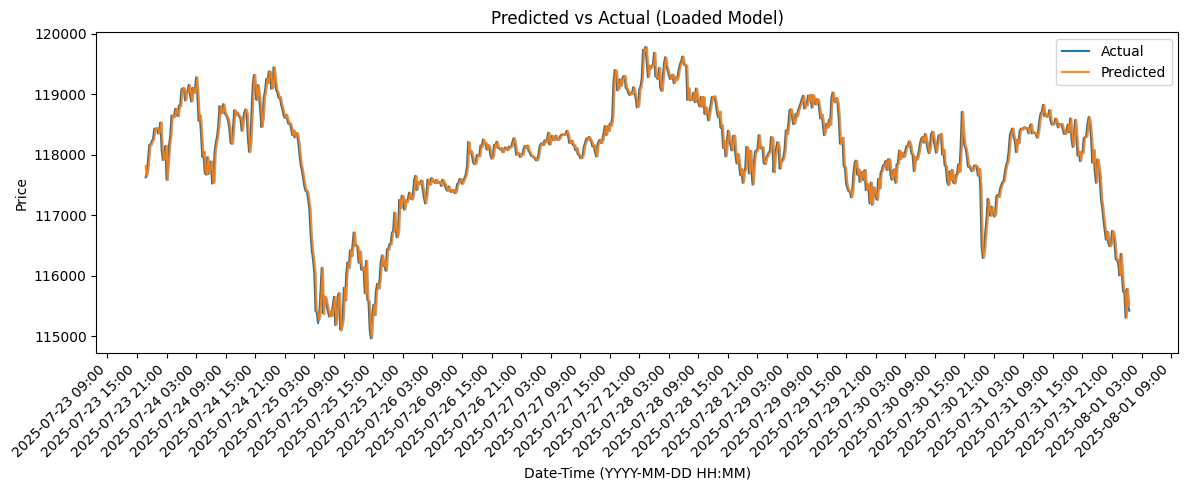

In [7]:
import pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
df = pd.read_csv('inference_from_saved.csv', parse_dates=['datetime'])
plt.figure(figsize=(12, 5))
tail = df.tail(800)
plt.plot(tail['datetime'], tail['actual_price_t+1'], label='Actual')
plt.plot(tail['datetime'], tail['predicted_price_t+1'], label='Predicted', alpha=0.9)
plt.title('Predicted vs Actual (Loaded Model)')
plt.xlabel('Date-Time (YYYY-MM-DD HH:MM)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig('pred_vs_actual_loaded.png', dpi=140)
plt.show()


In [8]:
from google.colab import files
files.download('pred_vs_actual_loaded.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1-min] Using CSV: btcusd_1-min_data.csv
After resampling (1T): (1356820, 6) 2023-01-01 00:00:00 -> 2025-08-01 00:59:00
Shapes (1-min, no-leak): (976737, 30) (108526, 30) (271315, 30)
[0]	train-rmse:6.59702	valid-rmse:7.86874
[1]	train-rmse:6.59697	valid-rmse:7.86871
[2]	train-rmse:6.59693	valid-rmse:7.86866
[3]	train-rmse:6.59684	valid-rmse:7.86873
[4]	train-rmse:6.59679	valid-rmse:7.86876
[5]	train-rmse:6.59672	valid-rmse:7.86855
[6]	train-rmse:6.59665	valid-rmse:7.86844
[7]	train-rmse:6.59660	valid-rmse:7.86842
[8]	train-rmse:6.59656	valid-rmse:7.86836
[9]	train-rmse:6.59652	valid-rmse:7.86844
[10]	train-rmse:6.59649	valid-rmse:7.86837
[11]	train-rmse:6.59647	valid-rmse:7.86847
[12]	train-rmse:6.59642	valid-rmse:7.86844
[13]	train-rmse:6.59639	valid-rmse:7.86828
[14]	train-rmse:6.59636	valid-rmse:7.86831
[15]	train-rmse:6.59628	valid-rmse:7.86808
[16]	train-rmse:6.59626	valid-rmse:7.86803
[17]	train-rmse:6.59621	valid-rmse:7.86799
[18]	train-rmse:6.59617	valid-rmse:7.86796
[19]	trai

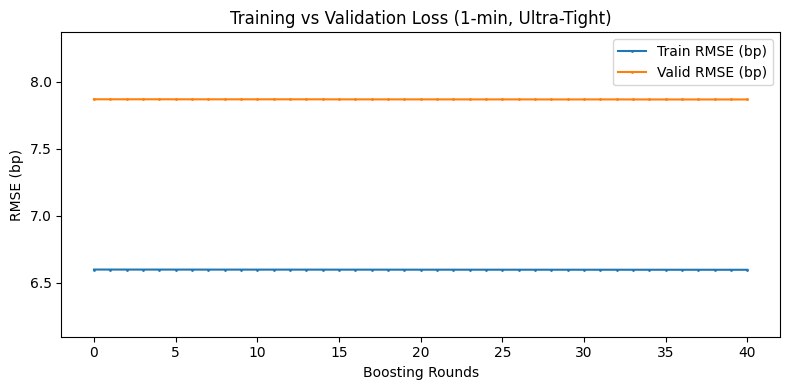

Saved -> rmse_curve_1min_bp_rmse_ultratight.png
Valid min: 7.867 bp at iter 35
[Model-1min UltraTight] Price MAE:36.98  RMSE:59.72  MSE:3,566.30  MAPE:0.0385%  R^2:0.999973
[LogRet]                 MAE:0.000385  RMSE:0.000636  Directional Accuracy:48.01%
[Naive-1min]           Price MAE:36.97  RMSE:59.73  MAPE:0.0385%  R^2:0.999973
Saved -> metrics_xgb_1min_bp_rmse_ultratight.csv
Saved -> predictions_test_1min_bp_rmse_ultratight.csv


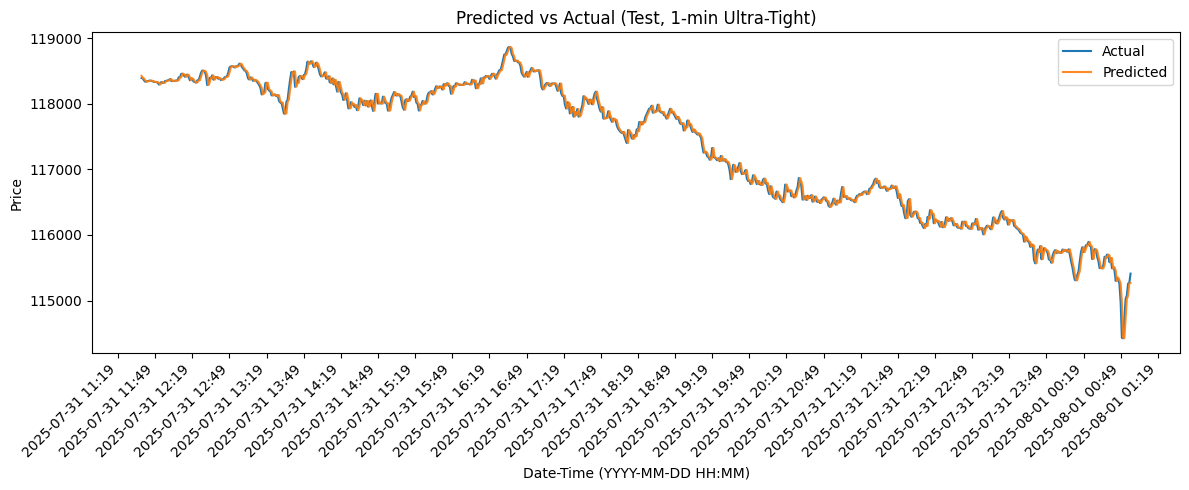

Saved -> pred_vs_actual_1min_bp_rmse_ultratight.png
Saved models & meta -> models_1min_bp_rmse_ultratight/xgb_model.json models_1min_bp_rmse_ultratight/xgb_model.ubj models_1min_bp_rmse_ultratight/xgb_config.json models_1min_bp_rmse_ultratight/xgb_meta.json


In [9]:
import os, json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
if 'SEED' not in globals():
    SEED = 42
if 'TEST_RATIO' not in globals():
    TEST_RATIO = 0.2
if 'VALID_RATIO' not in globals():
    VALID_RATIO = 0.1
RESAMPLE_RULE = '1T'
START_DATE = '2023-01-01'
TARGET_HORIZON = 1
N_PLOT_POINTS = 800
LAGS = [1, 2, 5, 15, 60, 240]
ROLL_WINDOWS = [15, 60, 240]
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'max_depth': 2, 'eta': 0.03, 'min_child_weight': 20, 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.5, 'lambda': 3.0, 'alpha': 0.3, 'max_bin': 256, 'base_score': 0.0, 'seed': SEED}
num_boost_round = 300
early_stopping_rounds = 5
OUT_DIR = 'models_1min_bp_rmse_ultratight'
os.makedirs(OUT_DIR, exist_ok=True)
METRICS_CSV = 'metrics_xgb_1min_bp_rmse_ultratight.csv'
PRED_CSV = 'predictions_test_1min_bp_rmse_ultratight.csv'
CURVE_PNG = 'rmse_curve_1min_bp_rmse_ultratight.png'
PLOT_PNG = 'pred_vs_actual_1min_bp_rmse_ultratight.png'
MODEL_JSON = os.path.join(OUT_DIR, 'xgb_model.json')
MODEL_UBJ = os.path.join(OUT_DIR, 'xgb_model.ubj')
MODEL_CFG = os.path.join(OUT_DIR, 'xgb_config.json')
MODEL_META = os.path.join(OUT_DIR, 'xgb_meta.json')
csv_path = None
for cand in ['btcusd_1-min_data.csv', 'BTCUSD_1min.csv', 'data.csv']:
    if os.path.exists(cand):
        csv_path = cand
        break
if csv_path is None:
    files = [p for p in os.listdir('.') if p.endswith('.csv')]
    if files:
        files.sort(key=lambda p: os.path.getsize(p), reverse=True)
        csv_path = files[0]
if csv_path is None:
    raise RuntimeError('No CSV found. Please upload your 1-min OHLCV CSV.')
print(f'[1-min] Using CSV: {csv_path}')
df_1m = read_and_resample_large_csv(csv_path, start_date=START_DATE, rule=RESAMPLE_RULE)
print('After resampling (1T):', df_1m.shape, df_1m['datetime'].min(), '->', df_1m['datetime'].max())
feat_df = make_features(df_1m)
del df_1m
feat_df['target'] = (np.log(feat_df['Close'].shift(-TARGET_HORIZON)) - np.log(feat_df['Close'])).astype('float32')
feat_df.replace([np.inf, -np.inf], np.nan, inplace=True)
feat_df.dropna(subset=['target'], inplace=True)
feat_df.reset_index(drop=True, inplace=True)
FEATURES = [c for c in feat_df.columns if c not in ('datetime', 'target', 'fwd_ret_1')]
assert 'target' not in FEATURES and 'fwd_ret_1' not in FEATURES, 'Leakage detected.'
X = feat_df[FEATURES].astype('float32').values
y = feat_df['target'].astype('float32').values
dt_vec = pd.to_datetime(feat_df['datetime']).values
CLOSE_VEC = feat_df['Close'].astype('float32').values
n = len(feat_df)
trn_sz, val_sz, tst_sz = time_series_splits(n, TEST_RATIO, VALID_RATIO)
X_train, y_train = (X[:trn_sz], y[:trn_sz])
X_valid, y_valid = (X[trn_sz:trn_sz + val_sz], y[trn_sz:trn_sz + val_sz])
X_test, y_test = (X[trn_sz + val_sz:], y[trn_sz + val_sz:])
dt_test = dt_vec[trn_sz + val_sz:]
base_test = CLOSE_VEC[trn_sz + val_sz:]

def _clean_xyb(X, y, b):
    m = np.isfinite(X).all(axis=1) & np.isfinite(y) & np.isfinite(b)
    return (X[m], y[m], b[m], m)
X_train, y_train, _, _ = _clean_xyb(X_train, y_train, np.ones_like(y_train))
X_valid, y_valid, _, _ = _clean_xyb(X_valid, y_valid, np.ones_like(y_valid))
X_test, y_test, base_test, m = _clean_xyb(X_test, y_test, base_test)
dt_test = dt_test[m]
print('Shapes (1-min, no-leak):', X_train.shape, X_valid.shape, X_test.shape)
LABEL_SCALE = 10000.0
y_train_bp = y_train * LABEL_SCALE
y_valid_bp = y_valid * LABEL_SCALE
dtrain = xgb.DMatrix(X_train, label=y_train_bp)
dvalid = xgb.DMatrix(X_valid, label=y_valid_bp)
dtest = xgb.DMatrix(X_test)
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtrain, 'train'), (dvalid, 'valid')], early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=1)
best_iter = getattr(bst, 'best_iteration', None)
print('Best iteration (0-based):', best_iter)
train_curve_bp = np.array(evals_result['train']['rmse'])
valid_curve_bp = np.array(evals_result['valid']['rmse'])
plt.figure(figsize=(8, 4))
plt.plot(train_curve_bp, label='Train RMSE (bp)', marker='.', ms=2)
plt.plot(valid_curve_bp, label='Valid RMSE (bp)', marker='.', ms=2)
lo, hi = (float(min(train_curve_bp.min(), valid_curve_bp.min())), float(max(train_curve_bp.max(), valid_curve_bp.max())))
pad = max(0.5, 0.02 * (hi - lo))
plt.ylim(lo - pad, hi + pad)
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE (bp)')
plt.title('Training vs Validation Loss (1-min, Ultra-Tight)')
plt.legend()
plt.tight_layout()
plt.savefig(CURVE_PNG, dpi=140)
plt.show()
print('Saved ->', CURVE_PNG)
print(f'Valid min: {valid_curve_bp.min():.3f} bp at iter {int(np.argmin(valid_curve_bp))}')
if best_iter is not None:
    y_pred_bp = bst.predict(dtest, iteration_range=(0, best_iter + 1))
else:
    y_pred_bp = bst.predict(dtest)
y_pred_lr = y_pred_bp / LABEL_SCALE
y_true_price = base_test * np.exp(y_test)
y_pred_price = base_test * np.exp(y_pred_lr)
mae = mean_absolute_error(y_true_price, y_pred_price)
mse = mean_squared_error(y_true_price, y_pred_price)
rmse = math.sqrt(mse)
mape = np.abs((y_true_price - y_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2 = r2_score(y_true_price, y_pred_price)
ret_rmse = math.sqrt(np.mean((y_test - y_pred_lr) ** 2))
ret_mae = mean_absolute_error(y_test, y_pred_lr)
hit_rate = (np.sign(y_test) == np.sign(y_pred_lr)).mean()
print(f'[Model-1min UltraTight] Price MAE:{mae:,.2f}  RMSE:{rmse:,.2f}  MSE:{mse:,.2f}  MAPE:{mape:.4f}%  R^2:{r2:.6f}')
print(f'[LogRet]                 MAE:{ret_mae:.6f}  RMSE:{ret_rmse:.6f}  Directional Accuracy:{hit_rate:.2%}')
naive_pred_price = base_test
mae_b = mean_absolute_error(y_true_price, naive_pred_price)
mse_b = mean_squared_error(y_true_price, naive_pred_price)
rmse_b = math.sqrt(mse_b)
mape_b = np.abs((y_true_price - naive_pred_price) / np.where(y_true_price == 0, 1e-06, y_true_price)).mean() * 100.0
r2_b = r2_score(y_true_price, naive_pred_price)
print(f'[Naive-1min]           Price MAE:{mae_b:,.2f}  RMSE:{rmse_b:,.2f}  MAPE:{mape_b:.4f}%  R^2:{r2_b:.6f}')
pd.DataFrame([{'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'MAPE(%)': mape, 'R2': r2, 'ret_RMSE': ret_rmse, 'ret_MAE': ret_mae, 'directional_accuracy': hit_rate, 'baseline_MAE': mae_b, 'baseline_RMSE': rmse_b, 'baseline_MAPE(%)': mape_b, 'baseline_R2': r2_b, 'best_iteration': best_iter, 'resample_rule': RESAMPLE_RULE, 'start_date': START_DATE, 'objective': params['objective'], 'eval_metric': params['eval_metric'], 'label_scale': LABEL_SCALE, 'target_type': 'log_return', 'ultra_tight': True}]).to_csv(METRICS_CSV, index=False)
print('Saved ->', METRICS_CSV)
out = pd.DataFrame({'datetime': pd.to_datetime(dt_test), 'base_price_t': base_test.astype('float64'), 'true_logret': y_test.astype('float64'), 'pred_logret': y_pred_lr.astype('float64'), 'actual_price_t+1': y_true_price.astype('float64'), 'predicted_price_t+1': y_pred_price.astype('float64'), 'pred_logret_bp': y_pred_bp.astype('float64')})
out.to_csv(PRED_CSV, index=False)
print('Saved ->', PRED_CSV)
plt.figure(figsize=(12, 5))
start_idx = max(0, len(y_true_price) - N_PLOT_POINTS)
plt.plot(dt_test[start_idx:], y_true_price[start_idx:], label='Actual')
plt.plot(dt_test[start_idx:], y_pred_price[start_idx:], label='Predicted', alpha=0.9)
plt.title('Predicted vs Actual (Test, 1-min Ultra-Tight)')
plt.xlabel('Date-Time (YYYY-MM-DD HH:MM)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_PNG, dpi=140)
plt.show()
print('Saved ->', PLOT_PNG)
bst.save_model(MODEL_JSON)
bst.save_model(MODEL_UBJ)
cfg = bst.save_config()
open(MODEL_CFG, 'w').write(cfg)
meta = {'best_iteration': int(best_iter) if best_iter is not None else None, 'features': FEATURES, 'resample_rule': RESAMPLE_RULE, 'target_horizon': TARGET_HORIZON, 'start_date': START_DATE, 'objective': params['objective'], 'eval_metric': params['eval_metric'], 'label_scale': LABEL_SCALE, 'target_type': 'log_return', 'ultra_tight': True}
with open(MODEL_META, 'w', encoding='utf-8') as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)
print('Saved models & meta ->', MODEL_JSON, MODEL_UBJ, MODEL_CFG, MODEL_META)


First 5 valid rmse: ['7.86873512', '7.86871395', '7.86865814', '7.86873388', '7.86875813']
Best valid rmse: 7.86734358 at iter 35
Last 5 valid rmse: ['7.86736733', '7.86741420', '7.86737658', '7.86741258', '7.86737698']


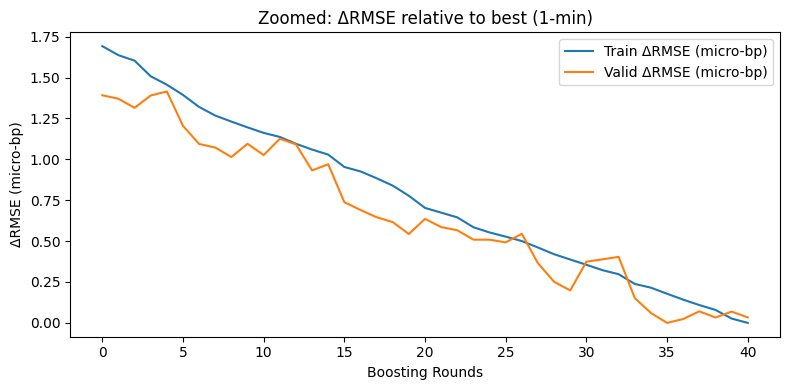

In [10]:
import numpy as np, matplotlib.pyplot as plt
train = np.array(evals_result['train']['rmse'])
valid = np.array(evals_result['valid']['rmse'])
print('First 5 valid rmse:', [f'{v:.8f}' for v in valid[:5]])
print('Best valid rmse:', f'{valid.min():.8f}', 'at iter', int(valid.argmin()))
print('Last 5 valid rmse:', [f'{v:.8f}' for v in valid[-5:]])
valid_delta_microbp = (valid - valid.min()) * 1000.0
train_delta_microbp = (train - train.min()) * 1000.0
plt.figure(figsize=(8, 4))
plt.plot(train_delta_microbp, label='Train ΔRMSE (micro-bp)')
plt.plot(valid_delta_microbp, label='Valid ΔRMSE (micro-bp)')
plt.ylabel('ΔRMSE (micro-bp)')
plt.xlabel('Boosting Rounds')
plt.title('Zoomed: ΔRMSE relative to best (1-min)')
plt.legend()
plt.tight_layout()
plt.show()
